# Federal Reserve Minutes Sentiment Analysis 

The objective of this notebook is to extract topics and sentiment from Federal Minutes (2004-Present), leveraging natural language techniques such as bag of words and Latent Dirichlet Allocation (LDA). Sentiment is calculated using FinBert


# <a name="data-o"></a> Data Overview
Data was web scrapped using [Webscraper.py]from https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm and saved in the directory below. 
The year 2004 was chosen as the start-year given the acceleration of release dates to 3 weeks, and improved clarity in explanations of committee’s decisions and views [(Danker,2005)](https://www.federalreserve.gov/pubs/bulletin/2005/spring05_fomc.pdf)

<br> 
In this section we will examine the transcripts' structure.

## <a name="sum"></a>Summary

In [126]:
pip_packages = [
    "charset-normalizer==2.0.10",
    "cycler==0.11.0",
    "filelock==3.4.2",
    "flake8==4.0.1",
    "fonttools==4.29.0",
    "funcy==1.17",
    "future==0.18.2",
    "gensim==4.1.2",
    "huggingface-hub==0.4.0",
    "idna==3.3",
    "jinja2==3.0.3",
    "joblib==1.1.0",
    "kiwisolver==1.3.2",
    "markupsafe==2.0.1",
    "matplotlib==3.5.1",
    "mccabe==0.6.1",
    "nltk==3.6.7",
    "numexpr==2.8.1",
    "numpy==1.22.1",
    "packaging==21.3",
    "pandas==1.4.0",
    "pep8==1.7.1",
    "pillow==9.0.0",
    "pycodestyle==2.8.0",
    "pyflakes==2.4.0",
    "pyldavis==3.3.1",
    "pyparsing==3.0.7",
    "pytz==2021.3",
    "pyyaml==6.0",
    "regex==2022.1.18",
    "requests==2.27.1",
    "sacremoses==0.0.47",
    "scikit-learn==1.0.2",
    "scipy==1.7.3",
    "seaborn==0.11.2",
    "sklearn==0.0",
    "smart-open==5.2.1",
    "threadpoolctl==3.0.0",
    "tokenizers==0.11.4",
    "torch==1.10.2",
    "tqdm==4.62.3",
    "transformers==4.16.1",
    "urllib3==1.26.8"
]

# Generate pip install commands
for package in pip_packages:
    print(f"pip install {package}")


pip install charset-normalizer==2.0.10
pip install cycler==0.11.0
pip install filelock==3.4.2
pip install flake8==4.0.1
pip install fonttools==4.29.0
pip install funcy==1.17
pip install future==0.18.2
pip install gensim==4.1.2
pip install huggingface-hub==0.4.0
pip install idna==3.3
pip install jinja2==3.0.3
pip install joblib==1.1.0
pip install kiwisolver==1.3.2
pip install markupsafe==2.0.1
pip install matplotlib==3.5.1
pip install mccabe==0.6.1
pip install nltk==3.6.7
pip install numexpr==2.8.1
pip install numpy==1.22.1
pip install packaging==21.3
pip install pandas==1.4.0
pip install pep8==1.7.1
pip install pillow==9.0.0
pip install pycodestyle==2.8.0
pip install pyflakes==2.4.0
pip install pyldavis==3.3.1
pip install pyparsing==3.0.7
pip install pytz==2021.3
pip install pyyaml==6.0
pip install regex==2022.1.18
pip install requests==2.27.1
pip install sacremoses==0.0.47
pip install scikit-learn==1.0.2
pip install scipy==1.7.3
pip install seaborn==0.11.2
pip install sklearn==0.0
pip

In [55]:
import os
import pandas as pd
import numpy as np 
import re
import string

from utils.corpusutils import CorpusPreProcess, Document, Corpus
from utils.featureutils import FeatureProcessor,find_closest


from nltk.tokenize import WordPunctTokenizer
from nltk.data import LazyLoader
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from transformers import AutoTokenizer, AutoModelForSequenceClassification

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import jensenshannon
import torch
import joblib
import pickle
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings('ignore')

In [56]:

current_directory = os.getcwd()
root = os.path.join(current_directory,"Minutes")
word_tokenizer = WordPunctTokenizer()
sent_tokenizer = LazyLoader("tokenizers/punkt/english.pickle")
category_pattern = r'(\d{4})/*'
file_extension = r'*.txt'
file_pattern = r'(\d{8})/*'
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english') + list(string.punctuation) + ['u','.','s','--','-','."',',"','.)',')-','".','—','),'] 


fed_mins = CorpusPreProcess(root=root,file_extension = file_extension,
                            category_pattern=category_pattern,
                            file_pattern=file_pattern,
                            word_tokenizer = word_tokenizer,
                            sent_tokenizer=sent_tokenizer,
                            stemmer = stemmer,
                            lemmatizer = lemmatizer,
                            stop_words = stop_words
                            )

In [57]:
fed_mins_ids = fed_mins.get_file_ids()

print('Total number of files: '+str(len(fed_mins_ids)))
print('Number of paragraphs: '+str(len(fed_mins.get_paras())))
print('Number of sentences: '+str(len(fed_mins.get_sents())))
print('Number of words: '+str(len(fed_mins.get_words())))
print('\n'+'First file: '+ fed_mins_ids[0])
print('Last file: '+ fed_mins_ids[-1])

Total number of files: 162
Number of paragraphs: 17913
Number of sentences: 49573
Number of words: 1376300

First file: 20040128
Last file: 20240612


In [58]:
#For each Category
para_by_year = {}

for cat in fed_mins.get_category_ids():
    files = fed_mins.get_file_ids(category_id=cat)
    para_by_year[cat] = {'nparas':sum(len(fed_mins.get_paras(file_id=f)) for f in files)/len(files),
                        'nwords':sum(len(fed_mins.get_words(file_id=f)) for f in files)/len(files)}


<Axes: title={'center': 'Paragraphs and words overtime'}>

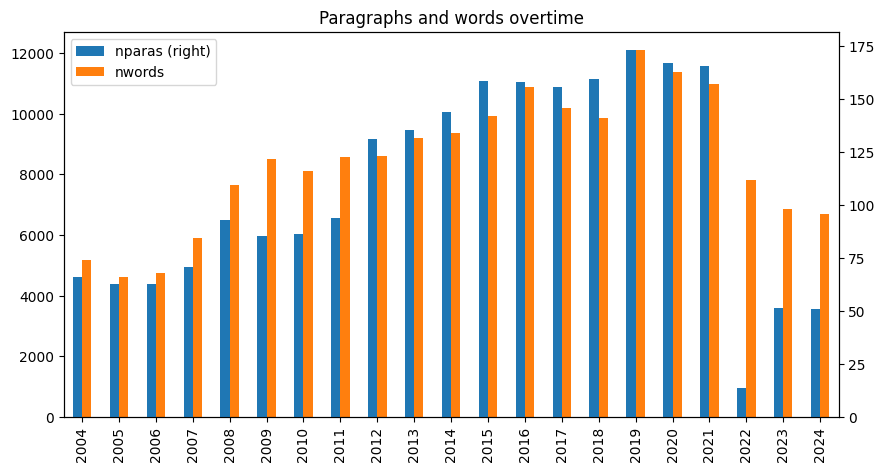

In [59]:
pd.DataFrame.from_dict(para_by_year).T.sort_index().plot(kind='bar',secondary_y='nparas',figsize=(10,5),title='Paragraphs and words overtime')


We can see an acceleration in the amount of paragraphs and words overtime.

In [60]:
start_regex = r"""(?i)(staff\sreview\sof\sthe\seconomic|the\sinformation\s[\s]?(?:reviewed|received|provided)|the\scommittee\sthen\sturned\sto\sa\sdiscussion\sof\sthe\seconomic\soutlook|in\sthe\scommittee[\']?s\sdiscussion\sof\scurrent\sand\sprospective\seconomic)"""
end_regex = r"""(?i)(at\sthe\sconclusion\sof\s[\s]?(?:the|this)\s(?:discussion|meetings)|the\scommitte\svoted\sto\sauthorize|the\svote\sencompassed\sapproval\sof)"""
file_stats = fed_mins.truncate_text(start_regex,end_regex,return_stats=True)

Overwritting existing folder
end_regex could not be found in 20220504.txt, defaulting to end of file


In [61]:
pd.Series(file_stats).rename('size_pct_change').to_frame().sort_values(by='size_pct_change')

,size_pct_change
20200129.txt,-60.414296
20190130.txt,-59.268669
20180131.txt,-58.432987
20140129.txt,-57.307791
20050202.txt,-56.184258
...,...
20221102.txt,-12.150198
20230322.txt,-10.266734
20221214.txt,-10.254278
20230201.txt,-9.318664


# Further pre-processing

In [62]:
file_example = '20171213'
sent_example = fed_mins.get_sents(file_id=file_example,stem=True,lemmatize=True)[32]
print('\033[1m'+"Example Sentence"+'\033[0m')
print(TreebankWordDetokenizer().detokenize(sent_example))

print('\n'+'\033[1m'+"Tokenize"+'\033[0m')
print(sent_example)

print('\n'+'\033[1m'+"Stem tokens"+'\033[0m')
sent_stemmed = sent_example.stem
print(sent_stemmed)

print('\n'+'\033[1m'+"Lemmatize tokens"+'\033[0m')
sent_lemmatized = sent_example.lemma
print(sent_lemmatized)

Example Sentence
Total U . S . consumer prices, as measured by the PCE price index, increased slightly more than 1 - 1 / 2 percent over the 12 months ending in October.

Tokenize
['Total', 'U', '.', 'S', '.', 'consumer', 'prices', ',', 'as', 'measured', 'by', 'the', 'PCE', 'price', 'index', ',', 'increased', 'slightly', 'more', 'than', '1', '-', '1', '/', '2', 'percent', 'over', 'the', '12', 'months', 'ending', 'in', 'October', '.']

Stem tokens
['total', 'consum', 'price', 'measur', 'pce', 'price', 'index', 'increas', 'slightli', 'percent', 'month', 'end', 'octob']

Lemmatize tokens
['total', 'consumer', 'price', 'measure', 'pce', 'price', 'index', 'increase', 'slightly', 'percent', 'month', 'end', 'october']


# LDA

In [63]:
import os
import re
import string
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from nltk.tokenize import WordPunctTokenizer
from nltk.data import LazyLoader
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Define directories
combined_dir = "Minutes_truncated"

# Preprocess the combined texts
stop_words = set(stopwords.words('english')) | {'u', 's', '--', '-', '."', ',"', '.)', ')-', '".', '—', '),'}
lemmatizer = WordNetLemmatizer()

# Preprocess and vectorize texts
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t not in stop_words and t.isalpha()]  # Remove stopwords and non-alphabetic tokens
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

texts = []
for file in os.listdir(root):
    if file.endswith(".txt"):
        with open(os.path.join(root, file), 'r', encoding='utf-8') as f:
            text = f.read()
            preprocessed_text = preprocess_text(text)
            texts.append(preprocessed_text)

# Ensure all elements in texts are strings
texts = [str(text) for text in texts if isinstance(text, str)]



In [64]:
print(f"Sample preprocessed text:\n{texts[0]}")

Sample preprocessed text:
meeting federal open market committee held office board governor federal reserve system washington wednesday november moskow santomero stern alternate member federal open market committee guynn lacker yellen president federal reserve bank atlanta richmond san francisco respectively connors fuhrer hakkio howard madigan slifman sniderman rasche wilcox associate economist ko manager system open market account ettin deputy director division research statistic board governor oliner struckmeyer associate director division research statistic board governor clouse whitesell deputy associate director division monetary affair board governor english assistant director division monetary affair board governor simpson senior adviser division research statistic board governor brady section chief division monetary affair board governor small project manager division monetary affair board governor skidmore special assistant board office board member board governor luecke senio

We want a balance between the # of topics, and how different everything is.

In [65]:
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Assuming the vectorizer and LDA model are already defined as per your script
# Vectorizer and model fitting

paras = fed_mins.get_paras(flatten=True,stem=True)
def return_self(x):return x

vectorizer = CountVectorizer(tokenizer=return_self, lowercase=False, preprocessor=return_self)
bag_of_words = vectorizer.fit_transform((doc.stem for doc in paras))

num_topics_6 = 6
lda_model_6 = LDA(n_components=num_topics_6, max_iter=20, learning_method='online', random_state=10, n_jobs=-1)
lda_transform_6 = lda_model_6.fit_transform(bag_of_words)

# Function to summarize topics
def summarize_topics(model, feature_names, no_top_words):
    topics = pd.DataFrame()
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics["Topic %d:" % (topic_idx)] = top_words
    return topics

topics_6 = summarize_topics(lda_model_6, vectorizer.get_feature_names_out(), 10)
print("Topics for 6 topics:")
print(topics_6)

# Save the model and vectorizer as .pkl files
joblib_file_lda = "lda_model_6_topics.pkl"
joblib_file_vectorizer = "count_vectorizer.pkl"
joblib.dump(lda_model_6, joblib_file_lda)
joblib.dump(vectorizer, joblib_file_vectorizer)

print(f"LDA model with 6 topics saved as {joblib_file_lda}")
print(f"CountVectorizer saved as {joblib_file_vectorizer}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Topics for 6 topics:
  Topic 0:  Topic 1: Topic 2:  Topic 3:   Topic 4:  Topic 5:
0  quarter    inflat   inflat    growth     market  particip
1     loan  committe    price    econom     period      busi
2  increas  particip    labor   project       rate     spend
3     real    polici    month      year      yield     price
4   remain     would     rate     staff  intermeet    growth
5   declin    econom   measur   quarter       bank      note
6  continu    member  percent   economi    financi   continu
7   credit      rate     year      rate   treasuri    recent
8     sale     feder  increas  forecast       fund    sector
9   consum      risk   remain       gdp      secur    market
LDA model with 6 topics saved as lda_model_6_topics.pkl
CountVectorizer saved as count_vectorizer.pkl


In [66]:
## What are the most frequently used words
term_counts = {i:j for i, j in zip(vectorizer.get_feature_names_out(), bag_of_words.toarray().sum(axis=0))}
df_term_counts = pd.DataFrame(sorted(term_counts.items(), key=lambda x: x[1], reverse=True), columns=['term', 'count'])
df_term_counts.head(5)


,term,count
0,inflat,8917
1,rate,8116
2,price,7188
3,market,7030
4,particip,6949


In [67]:
df_results = summarize_topics(lda_model_6, vectorizer.get_feature_names_out(), 10)
df_results


,Topic 0:,Topic 1:,Topic 2:,Topic 3:,Topic 4:,Topic 5:
0,quarter,inflat,inflat,growth,market,particip
1,loan,committe,price,econom,period,busi
2,increas,particip,labor,project,rate,spend
3,real,polici,month,year,yield,price
4,remain,would,rate,staff,intermeet,growth
5,declin,econom,measur,quarter,bank,note
6,continu,member,percent,economi,financi,continu
7,credit,rate,year,rate,treasuri,recent
8,sale,feder,increas,forecast,fund,sector
9,consum,risk,remain,gdp,secur,market


In [36]:
pyLDAvis.lda_model.prepare(lda_model_6,bag_of_words,vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.045998 -0.105124       1        1  21.794739
1      0.241960 -0.016177       2        1  21.179457
0     -0.212509 -0.027031       3        1  16.360839
3     -0.001859 -0.064894       4        1  13.771225
4      0.007536  0.227637       5        1  13.656523
2     -0.081126 -0.014412       6        1  13.237218, topic_info=          Term         Freq        Total Category  logprob  loglift
1780    inflat  8974.000000  8974.000000  Default  30.0000  30.0000
662   committe  3817.000000  3817.000000  Default  29.0000  29.0000
2728     price  6996.000000  6996.000000  Default  28.0000  28.0000
2543  particip  7490.000000  7490.000000  Default  27.0000  27.0000
1565    growth  5261.000000  5261.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
2105    market   943.877442  6932.056389   Topic6  -4.4923   0.0282
763    continu   818.073782  5588.963696   Topic6  -4.6354   0.1005
1989     level   641.089381  3325.931343   Topic6  -4.8791   0.3758
2022     littl   566.550817  1771.639022   Topic6  -5.0027   0.8820
2817   quarter   569.767718  4782.563273   Topic6  -4.9971  -0.1054

[493 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
86        2  0.989598  achiev
86        6  0.006945  achiev
94        1  0.402720   activ
94        2  0.172060   activ
94        3  0.091017   activ
...     ...       ...     ...
4111      4  0.064823       ‑
4111      6  0.929131       ‑
4114      4  0.032867       –
4114      5  0.054778       –
4114      6  0.909318       –

[1083 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 1, 4, 5, 3])

In [39]:
!pip install pyLDAvis

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


Topic 0: Quarterly Economic Performance and Loans

Key Words: quarter, loan, increas, real, remain, declin, continu, credit, sale, consum
Representation: This topic likely covers discussions about quarterly economic performance, loan activities, and credit markets. Terms like "quarter" and "increas" suggest a focus on periodic economic updates, while "loan" and "credit" indicate financial activities related to lending and consumer credit.
Justification: The FOMC often reviews quarterly economic data and considers the state of the credit markets, which are critical for economic stability and growth.

Topic 1: Inflation and Monetary Policy

Key Words: inflat, committe, particip, polici, would, econom, member, rate, feder, risk
Representation: This topic focuses on inflation and the committee's policy decisions. Terms like "inflat" and "polici" are central to the FOMC's role, while "committe" and "member" indicate the decision-making process.
Justification: Inflation control is a primary objective of the FOMC, and this topic reflects the discussions around policy measures to manage inflation.

Topic 2: Price Levels and Labor Market

Key Words: inflat, price, labor, month, rate, measur, percent, year, increas, remain
Representation: This topic covers price levels, inflation measurements, and labor market conditions. Words like "price" and "labor" suggest a focus on employment and wage dynamics, which are closely tied to inflation.
Justification: Monitoring price levels and labor market conditions helps the FOMC assess economic health and inflationary pressures.

Topic 3: Economic Growth and Forecasts

Key Words: growth, econom, project, year, quarter, economi, rate, forecast, gdp, staff
Representation: This topic relates to overall economic growth, forecasts, and projections. Terms like "growth" and "project" suggest future-oriented discussions, while "gdp" and "rate" are key economic indicators.
Justification: Economic forecasts and growth projections are essential for the FOMC to plan and adjust monetary policy accordingly.

Topic 4: Market Conditions and Financial Stability

Key Words: market, period, rate, intermeet, bank, financi, treasuri, fund, secur, remain
Representation: This topic focuses on market conditions and financial stability. Words like "market," "rate," and "bank" point to discussions on interest rates, banking stability, and market operations.
Justification: Ensuring stable market conditions and a sound financial system is a core responsibility of the FOMC.

Topic 5: Business Activities and Consumer Spending

Key Words: particip, busi, spend, price, growth, note, continu, recent, sector, market
Representation: This topic covers business activities and consumer spending. Terms like "busi" and "spend" indicate a focus on economic activities at the business and consumer level.
Justification: Understanding business activities and consumer spending patterns helps the FOMC gauge economic momentum and adjust policies to support sustainable growth.

## <a name="finbert"></a>FinBERT
FinBERT is a pre-trained transformer model, specifically trained for the finance domain. https://github.com/ProsusAI/finBERT. The sentiment scoring component derives from Financial PhraseBank dataset. 
Here we will score each old text instead of our lemmatised 'new text'. 

Most documents have tokens less than the maximum model size, which means we don't have to worry about truncation, in fact we could probably truncate our tokens to 350

## for all

In [68]:
#Load tokenizer and model
transformer_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
transformer_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",output_hidden_states=True,output_attentions=False)
 

In [69]:
text = ['Participants','remarked','that','inflation','readings','had','been','higher','and','were','more','persistent','and','widespread','than','previously','anticipated','.']

In [70]:
print(transformer_tokenizer.convert_ids_to_tokens(transformer_tokenizer(paras[0].tokens,padding=True,is_split_into_words=True)['input_ids']))

Token indices sequence length is longer than the specified maximum sequence length for this model (596 > 512). Running this sequence through the model will result in indexing errors


['[CLS]', 'at', 'this', 'meeting', 'suggests', 'that', 'the', 'economy', 'has', 'been', 'growing', 'rather', 'slowly', 'in', 'recent', 'months', '.', 'non', '##far', '##m', 'payroll', 'employment', 'continued', 'to', 'expand', 'moderately', 'in', 'december', ',', 'and', 'the', 'civilian', 'unemployment', 'rate', 'remained', 'at', '5', '.', '6', 'percent', '.', 'industrial', 'production', 'increased', 'only', 'slightly', 'further', 'in', 'the', 'fourth', 'quarter', '.', 'growth', 'of', 'consumer', 'spending', 'was', 'modest', ',', 'on', 'balance', ',', 'over', 'the', 'past', 'several', 'months', '.', 'housing', 'starts', 'rebound', '##ed', 'in', 'november', 'from', 'a', 'sizable', 'october', 'decline', '.', 'orders', 'for', 'non', '##de', '##fen', '##se', 'capital', 'goods', 'point', 'to', 'a', 'mode', '##ration', 'in', 'the', 'expansion', 'of', 'spending', 'on', 'business', 'equipment', ',', 'and', 'non', '##res', '##ide', '##ntial', 'construction', 'has', 'risen', 'app', '##re', '##ci

In [71]:
#How many our of documents get truncated?
plengths = []
for p in paras:
    plengths.append(len(transformer_tokenizer.encode(p.tokens,padding=True,is_split_into_words=True)))

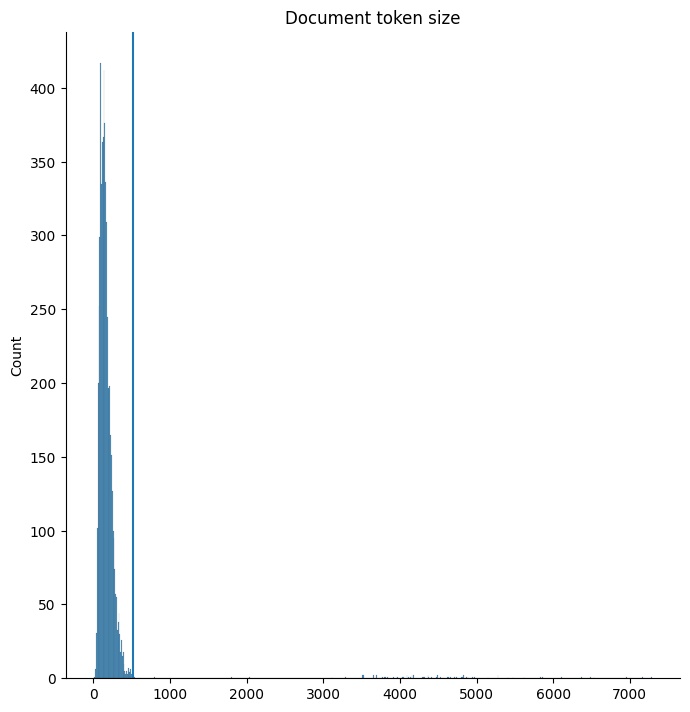

In [72]:

sns.displot(plengths,height=7).set(title='Document token size')
plt.axvline(transformer_tokenizer.model_max_length)

In [73]:
file_id = '20211215'
latest_minutes = fed_mins.get_paras(file_id = file_id,flatten=True,stem=True)
tokenizer_settings = dict(is_split_into_words=True,max_length=350,padding='max_length',truncation=True,return_tensors="pt")

document_feat = FeatureProcessor(latest_minutes,
                                transformer_model=transformer_model,
                                transformer_tokenizer=transformer_tokenizer,
                                tokenizer_settings=tokenizer_settings,
                                lda_model=lda_model_6,
                                lda_vec=vectorizer,
                                lda_topic_dict=topic_dict,batch_size=30)

In [74]:
latest_minutes = document_feat.get_features(sentiment=True,embedding=True,topic=True)


In [75]:
def corpus_stats(corpus):
    ids = [(n,f.category_id,f.file_id) for n,f in enumerate(corpus)]
    df_ids = pd.DataFrame(ids,columns=['idx','category_id','file_id'])
    start_idx = df_ids.drop_duplicates(['category_id','file_id'],keep='first')
    end_idx = df_ids.drop_duplicates(['category_id','file_id'],keep='last')

    idx = start_idx.merge(end_idx,on=['category_id','file_id'],suffixes=('_start','_end'))

    stats =[]
    corpus_sent = corpus.extract_features('sentiment')
    corpus_topic = corpus.extract_features('topics')

    for s,cat_id,file_id,e in idx.values:
        net_tone = [s['logits'][0] - s['logits'][1] for s in corpus_sent[s:e]]
        topic_dist = [s['topic_dist'] for s in corpus_topic[s:e]]
        topic_sentiment = np.asarray(topic_dist) * np.asarray(net_tone).reshape(-1,1)
        topic_mean_sent = topic_sentiment.mean(axis=0).tolist()

        stats.append((cat_id,file_id,*topic_mean_sent))
    return stats


latest_stats = corpus_stats(latest_minutes)
latest_stats = pd.DataFrame(latest_stats,columns = ['category_id','file_id']+list(topic_dict.values()))
latest_stats['month'] = pd.to_datetime(latest_stats['file_id']).dt.to_period('M')
latest_stats.set_index(['month'],inplace=True)

<Axes: title={'center': 'Average net-tone per topic for file:20211215'}, xlabel='month'>

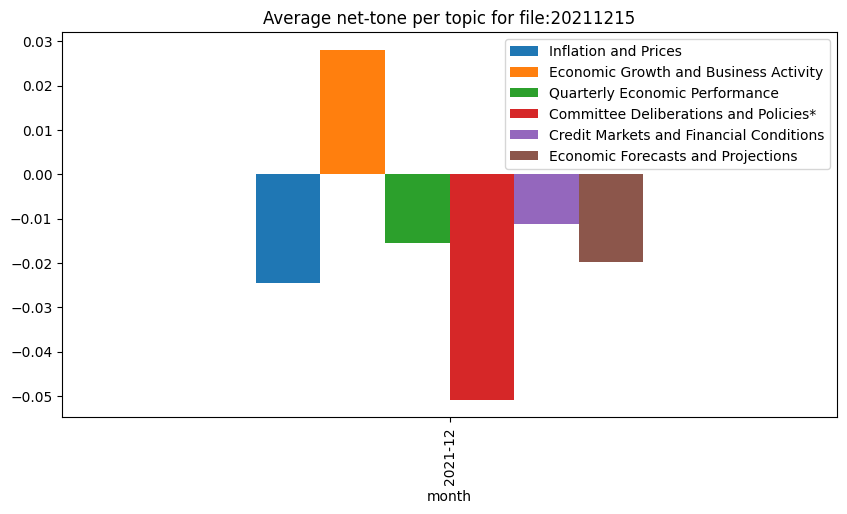

In [76]:
latest_stats.plot(kind='bar',title='Average net-tone per topic for file:{}'.format(file_id),figsize=(10,5))

  0%|          | 0/21 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
TOKENIZERS_PARALLELISM=(true | false)
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  5%|▍         | 1/21 [05:02<1:40:40, 302.03s/it]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the 

<Figure size 640x480 with 0 Axes>

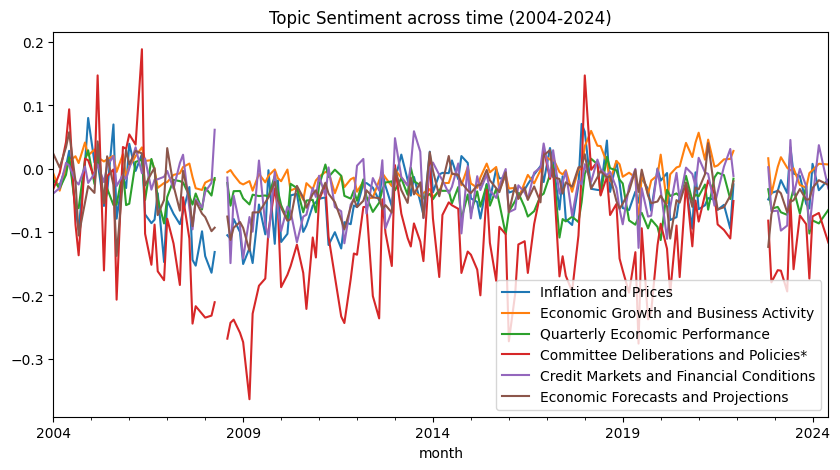

In [77]:
# Initialize an empty DataFrame for cumulative results
cumulative_stats = pd.DataFrame()

# Process data for each year from 2004 to 2024
for year in tqdm(range(2004, 2025)):
    last_year_minutes = fed_mins.get_paras(category_id=str(year), flatten=True, stem=True)

    document_feat = FeatureProcessor(
        last_year_minutes,
        transformer_model=transformer_model,
        transformer_tokenizer=transformer_tokenizer,
        tokenizer_settings=tokenizer_settings,
        lda_model=lda_model_6,
        lda_vec=vectorizer,
        lda_topic_dict=topic_dict,
        batch_size=30
    )
    last_year_minutes = document_feat.get_features()

    year_stats = pd.DataFrame(corpus_stats(last_year_minutes), columns=['category_id', 'file_id'] + list(topic_dict.values()))
    year_stats['month'] = pd.to_datetime(year_stats['file_id']).dt.to_period('M')
    year_stats.set_index(['month'], inplace=True)
    
    # Append to the cumulative DataFrame
    cumulative_stats = pd.concat([cumulative_stats, year_stats])

# Save the cumulative stats to a CSV file
cumulative_stats.to_csv('2004-2024-sentiment-by-topic.csv')

# Plot and save the cumulative figure
plt.figure()
cumulative_stats[[i for i in cumulative_stats.columns if i not in ['category_id', 'file_id']]].plot(
    kind='line', figsize=(10, 5), title='Topic Sentiment across time (2004-2024)')
plt.savefig('sentiment_plot_2004-2024.png')

### Mediator/Moderator Analysis ish

In [ ]:
"""
#Save Transformer models
save_path = os.path.join(current_directory,"Model")
if not os.path.exists(save_path):
    os.mkdir(save_path)

    
transformer_model.save_pretrained(os.path.join(save_path,"transformer_model"))
#Save LDA,vectorizer,topic_dictionary
transformer_tokenizer.save_pretrained(os.path.join(save_path,"transformer_tokenizer"))
#save tokenizer settings
pickle.dump(tokenizer_settings,open(os.path.join(save_path,"tokenizer_settings.pkl"),"wb"))

#save lda model

with open(os.path.join(save_path,"lda_models.pkl"),'wb') as models:
    pickle.dump((lda_model,vectorizer,topic_dict),models)

"""
